In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
from keras.models import Sequential 
from keras.layers import Conv2D 
from keras.layers import MaxPooling2D 
from keras.layers import LSTM 
from keras.layers import Dense 
from keras.layers import Flatten 
from keras.layers import TimeDistributed

In [3]:
# width, height, number of frame:
size = 50

In [4]:
# generate the next frame in the sequence 
def next_frame(last_step, column, size): 
    frame = np.zeros((size,size)) 
    # define the scope of the next step 
    lower = max(0, last_step-3) 
    upper = min(frame.shape[0]-1, last_step+3) 
    # choose the row index for the next step 
    step = random.randint(lower, upper) 
    # add the new step 
    cv2.circle(frame,(column, step),3,255,-1)
    #frame[step, column] = 1 
    return frame, step

In [5]:
# generate a sequence of frames of a dot moving across an image 
def build_frames(size): 
    frames = list() 

    step = random.randint(0, size-1) 
    # decide if we are heading left or right 
    right = 1 if random.random() < 0.5 else 0 
    col = 0 if right else size-1 

    # create all frames 
    for i in range(0, size): 
        col = i if right else size-1-i 
        frame, step = next_frame(step, col, size) 
        frames.append(frame) 
    return frames, right

In [6]:
# generate multiple sequences of frames and reshape for network input 
def generate_examples(size, n_patterns): 
    X, y = list(), list() 
    for _ in range(n_patterns): 
        frames, right = build_frames(size) 
        X.append(frames) 
        y.append(right) 
    # resize as [samples, timesteps, width, height, channels] 
    X = np.array(X).reshape(n_patterns, size, size, size, 1)
    y = np.array(y).reshape(n_patterns, 1) 
    return X, y

Right -->


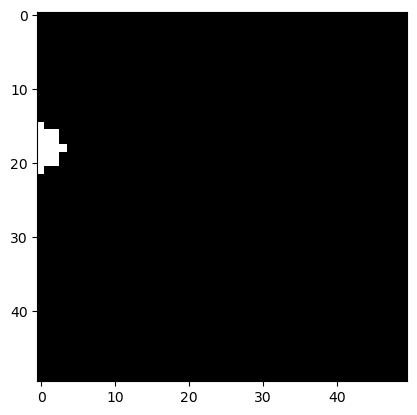

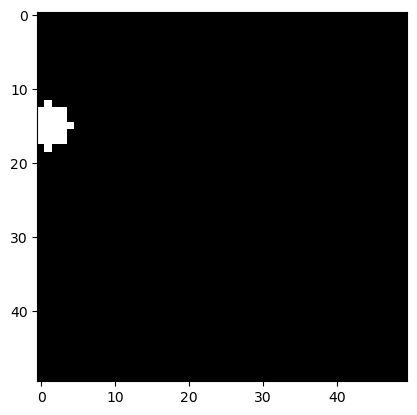

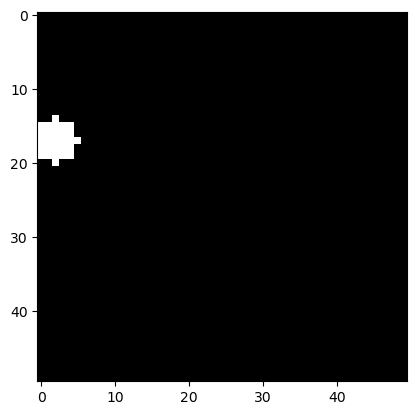

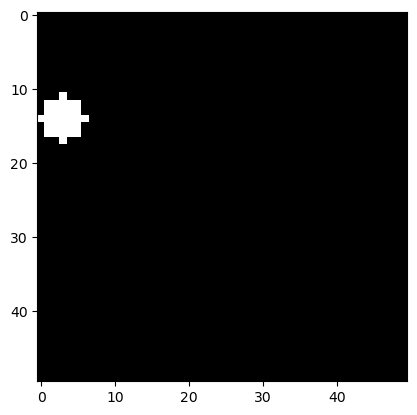

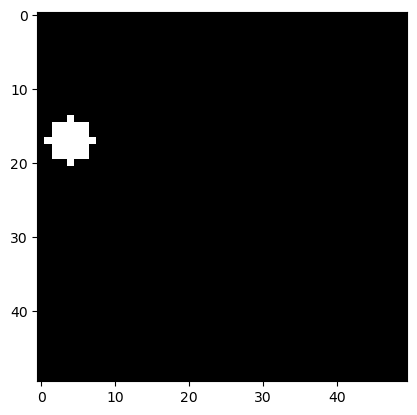

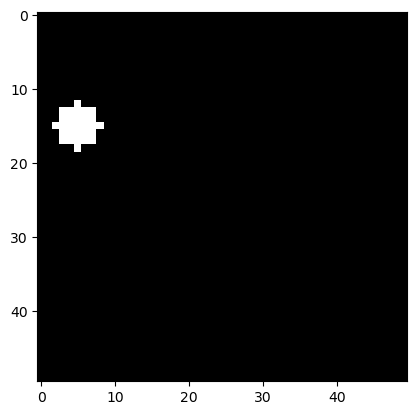

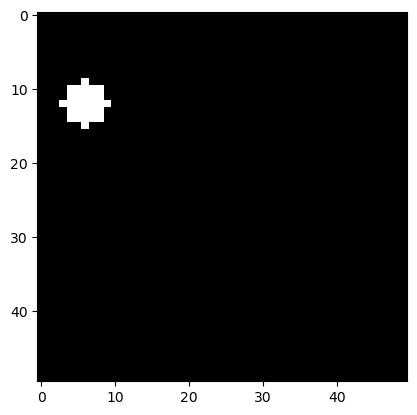

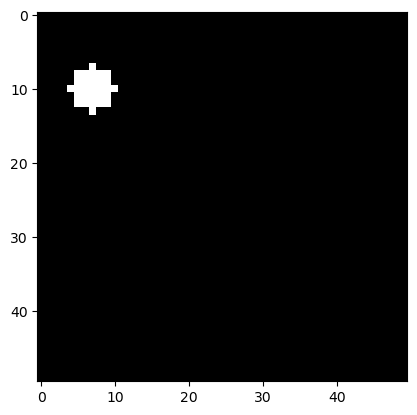

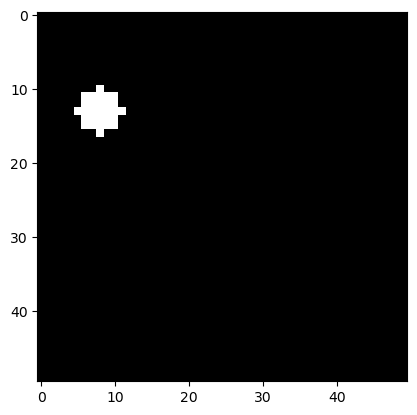

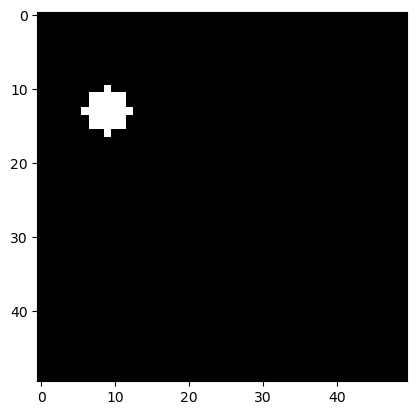

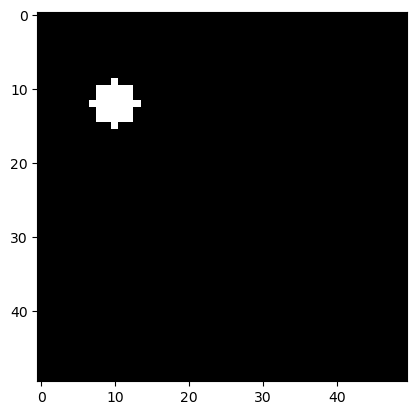

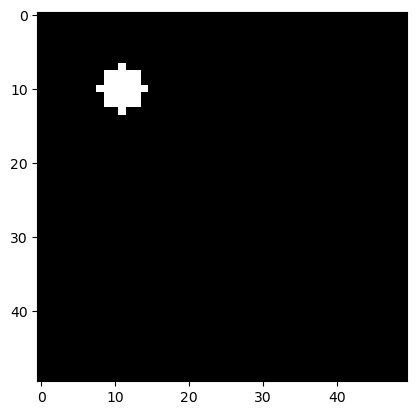

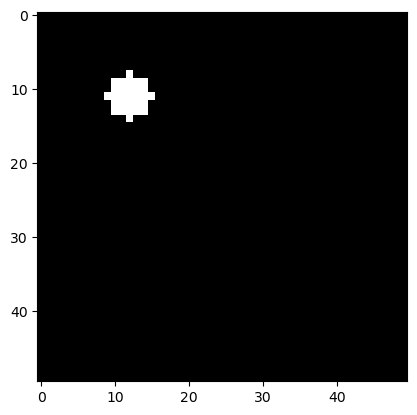

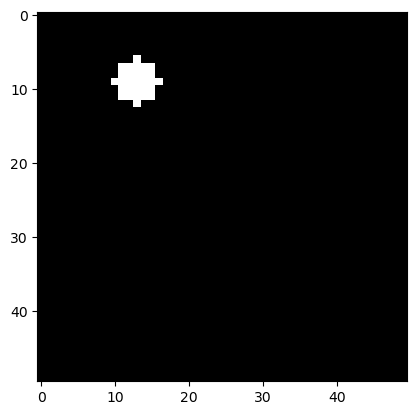

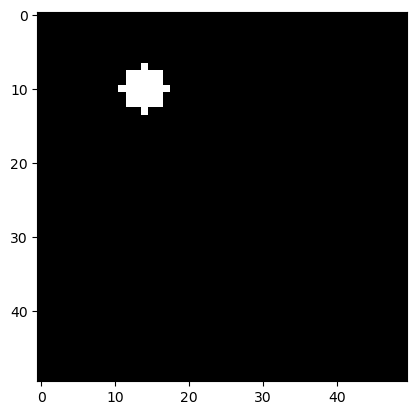

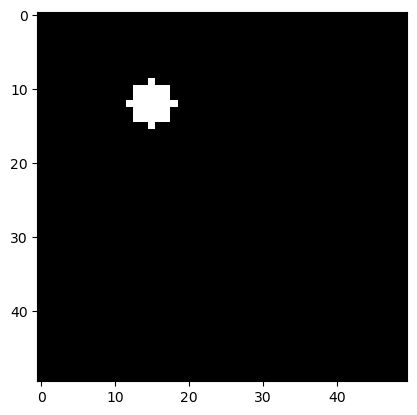

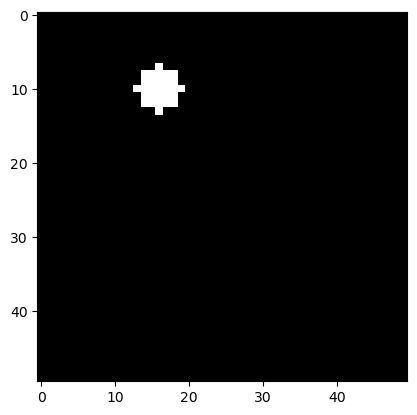

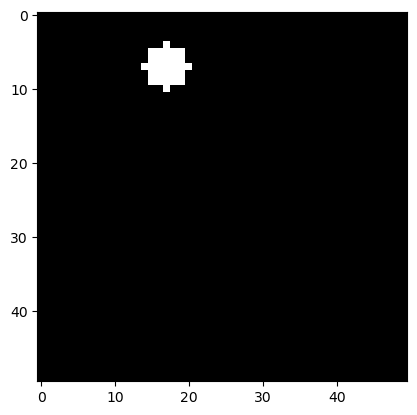

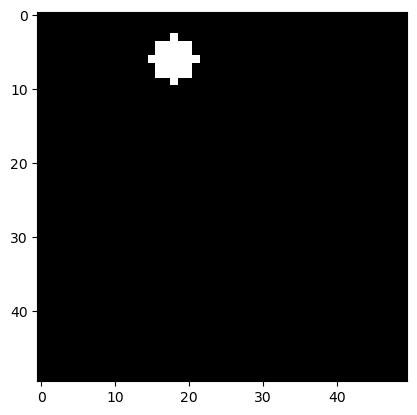

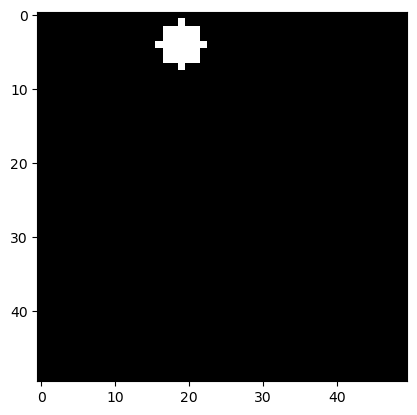

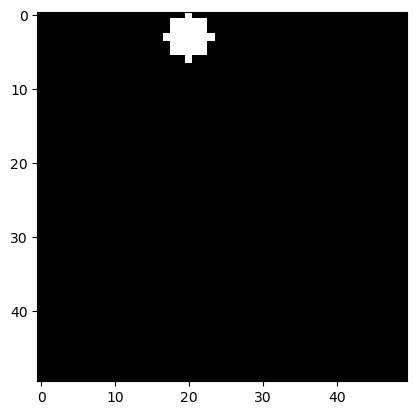

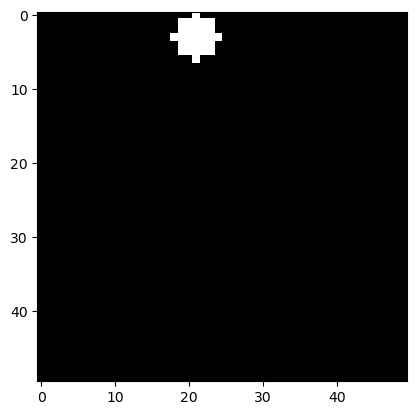

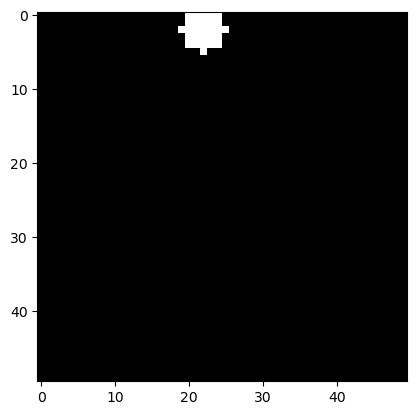

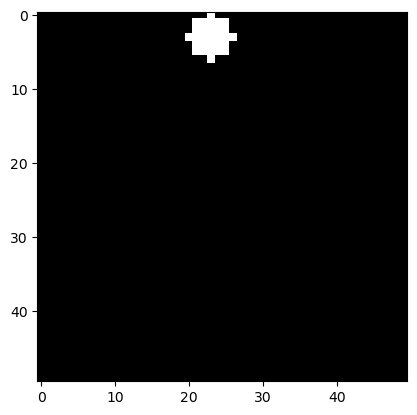

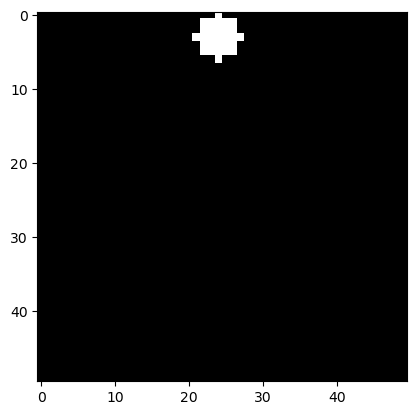

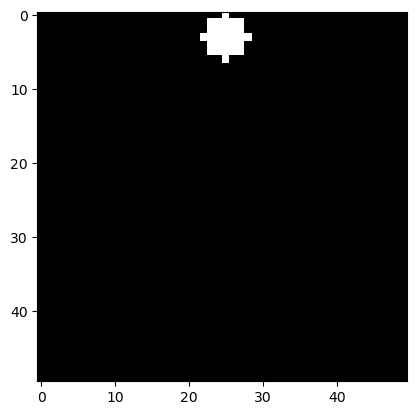

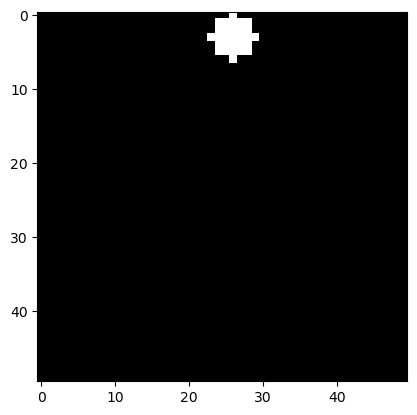

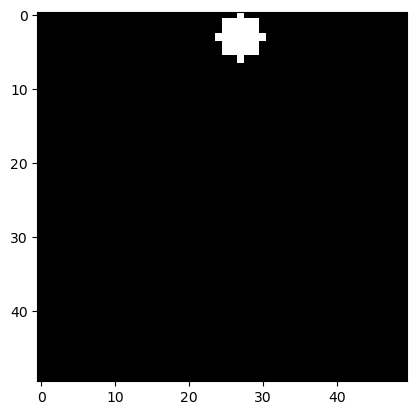

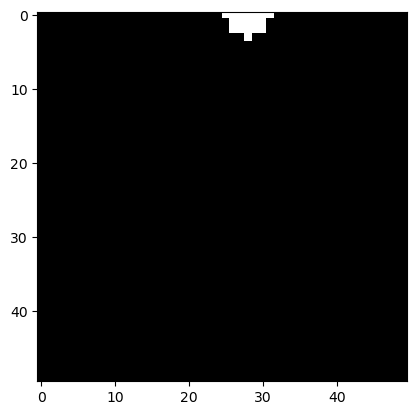

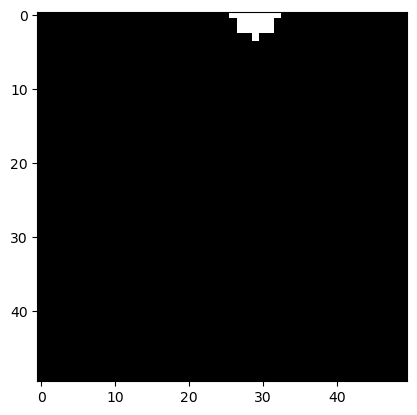

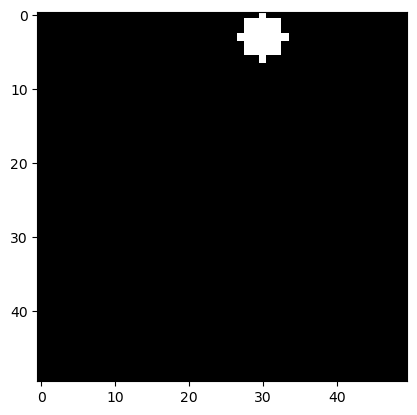

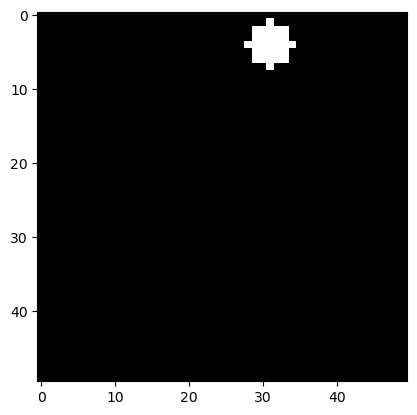

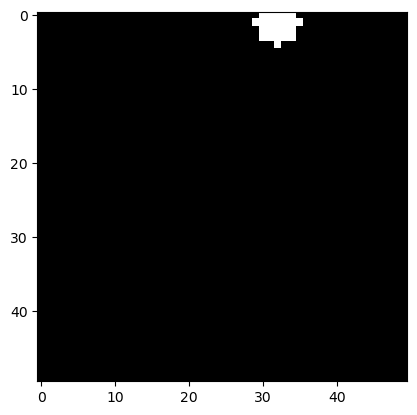

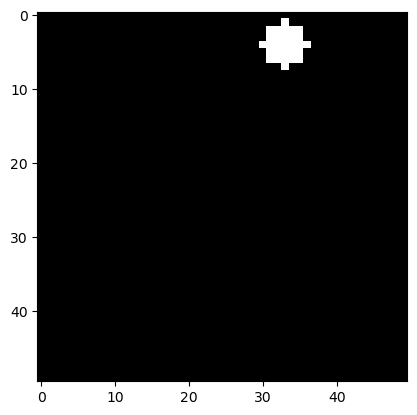

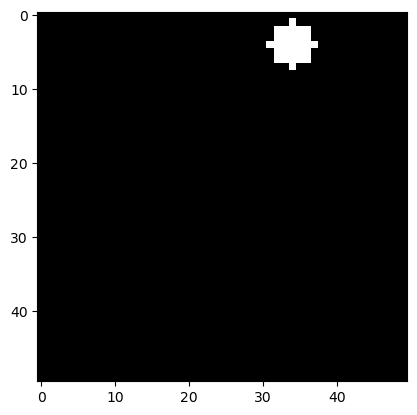

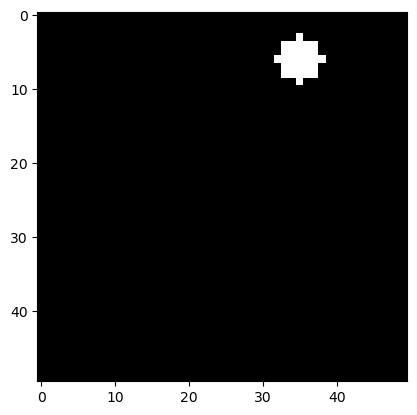

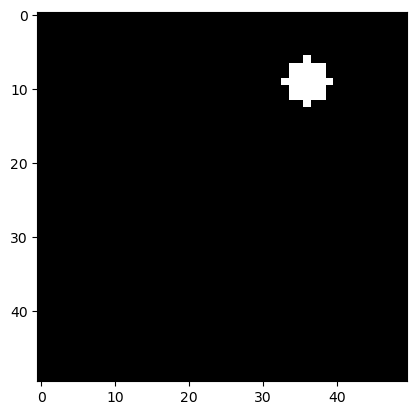

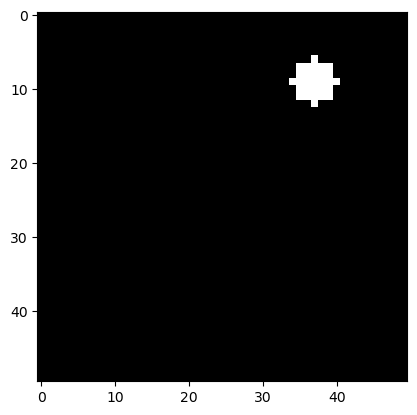

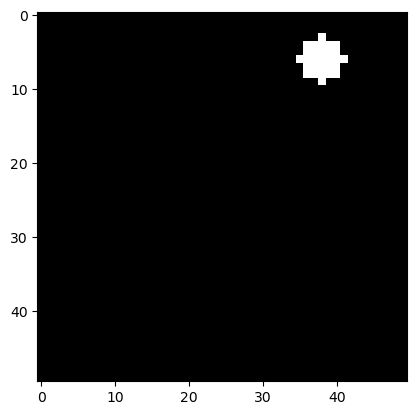

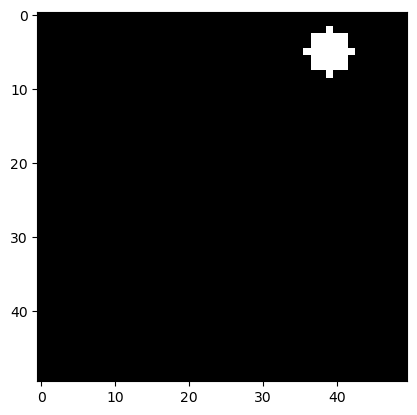

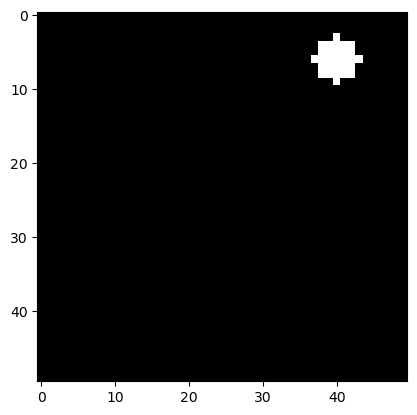

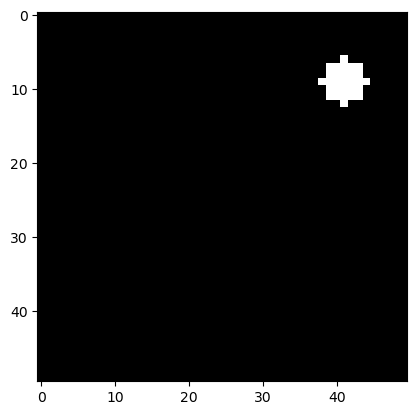

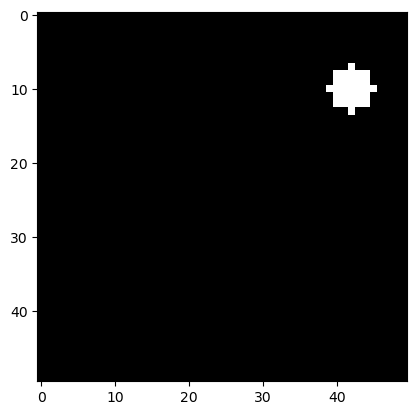

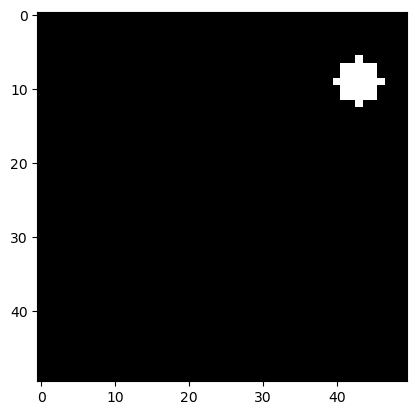

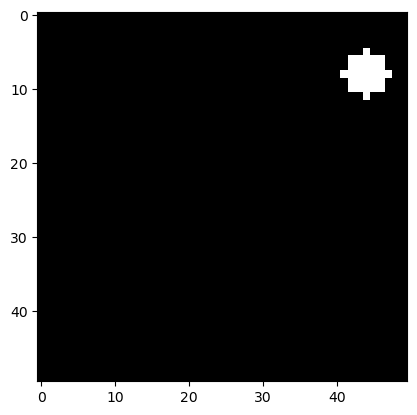

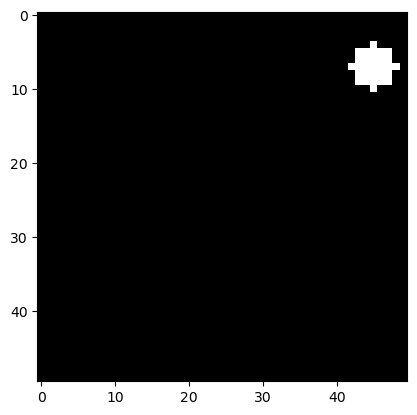

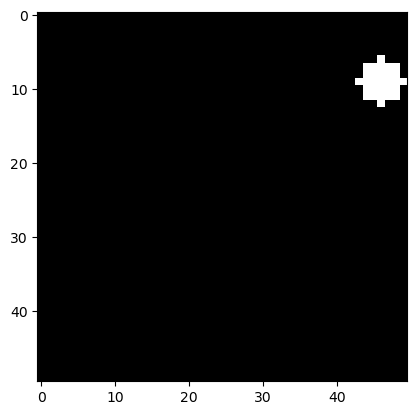

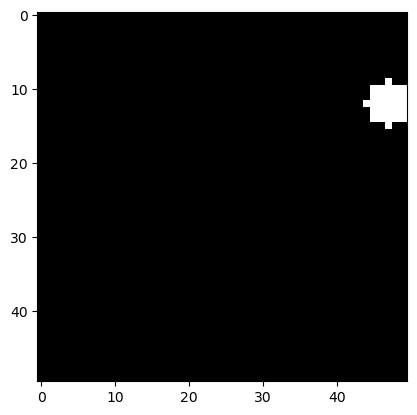

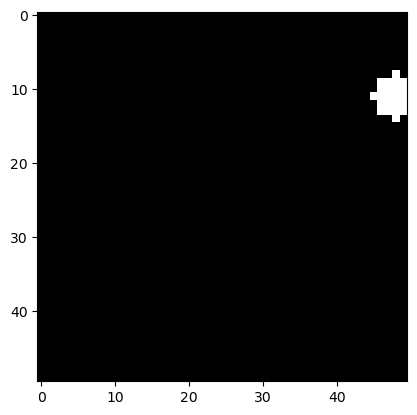

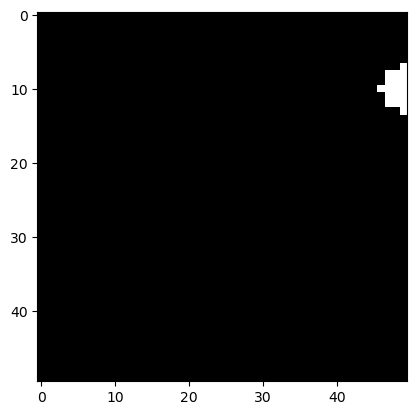

In [7]:
X, Y = generate_examples(size, 1) 
print("Right -->") if Y[0] else print("<-- Left")

for frame in X[0]:
    plt.imshow(frame[:,:,0], cmap="gray")
    plt.show()

In [9]:
# define the model 
model = Sequential() 
model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), 
                          input_shape=(None,size,size,1))) 
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2)))) 
model.add(TimeDistributed(Flatten())) 
model.add(LSTM(64)) 
model.add(Dense(1, activation='sigmoid')) 
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDi  (None, None, 48, 48, 8)   80        
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, None, 24, 24, 8)   0         
 stributed)                                                      
                                                                 
 time_distributed_5 (TimeDi  (None, None, 4608)        0         
 stributed)                                                      
                                                                 
 lstm_1 (LSTM)               (None, 64)                1196288   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                      

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='adam', metrics=['acc']) 

In [13]:
X, y = generate_examples(size, 1000) 
model.fit(X, y, batch_size=32, epochs=3)

Epoch 1/3
32/32 [==============================] - 10s 300ms/step - loss: 6.1057e-04 - acc: 1.0000
Epoch 2/3
32/32 [==============================] - 9s 294ms/step - loss: 4.8813e-04 - acc: 1.0000
Epoch 3/3
32/32 [==============================] - 9s 295ms/step - loss: 4.1202e-04 - acc: 1.0000


In [14]:
# evaluate model 
X, y = generate_examples(size, 100) 
loss, acc = model.evaluate(X, y, verbose=0) 
print('loss: %f, acc: %f' % (loss, acc*100))

loss: 0.000382, acc: 100.000000


In [15]:
# prediction on new data 
X, y = generate_examples(size, 1) 
predict_x=model.predict(X) 
yhat=np.argmax(predict_x,axis=1)
expected = "Right" if y[0]==1 else "Left" 
predicted = "Right" if yhat[0]==1 else "Left" 
print('Expected: %s, Predicted: %s' % (expected, predicted))

1/1 [==============================] - 0s 365ms/step
Expected: Left, Predicted: Left
